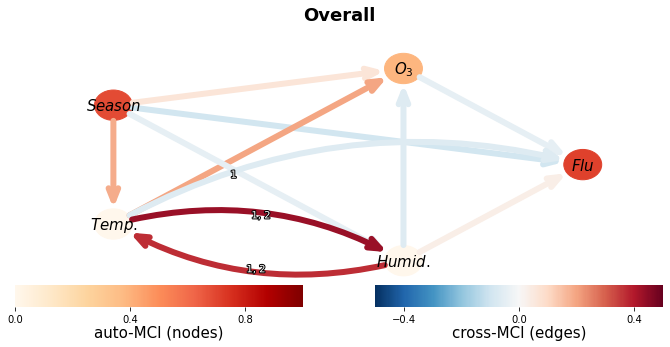

0.05


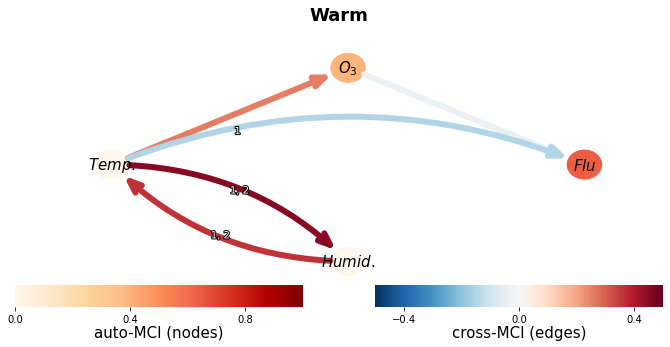

0.05


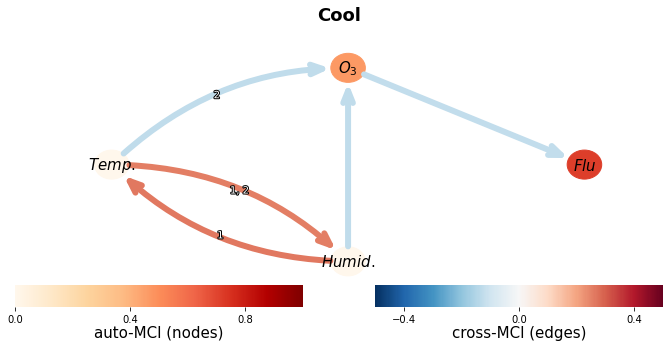

0.05


In [7]:
import pandas as pd
import os
import pyarrow.feather as feather
from matplotlib import pyplot as plt
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr
import numpy as np
# from tigramite.independence_tests import GPDC

os.chdir("//Mac/Home/Desktop/PRJ/USA_FLU")

data_all = pd.read_csv("usaflu_norm_M.csv")
data_all.rename(columns={'fluP': r'$Flu$',
                         'o3': r'$O_{3}$',
                         'season': r'$Season$',
                         'temp': r'$Temp.$',
                         'ah': r'$Humid.$'}, inplace=True)


# Function for preparing the values of the variables specified by 'var_names'
# in the state specified by 'state' as numpy array of shape (T, N), where
# T is the number of time steps and N the number of variables
def get_data(data_all, state, var_names=[r'$Flu$', r'$O_{3}$', r'$Season$',
                                         r'$Temp.$', r'$Humid.$']):
    # Select the state
    if state == "Overall":
        data_out = data_all
    else:
        data_out = data_all.loc[data_all[r'state'] == state]

    # Select the columns
    data_out = data_out[var_names]

    # Turn into numpy array
    data_out = data_out.values

    # Return
    return data_out
    # Return
    return data_out

def get_selected_links(var_names, tau_min, tau_max):
    
    # Get index of the season variable, if it exists
    if r'$Season$' in var_names:
        season_idx = np.argwhere(np.array(var_names) == r'$Season$')[0, 0]
    else:
        season_idx = None

    # Get index of the temperature variable, if it exists
    if r'$Temp.$' in var_names:
        temp_idx = np.argwhere(np.array(var_names) == r'$Temp.$')[0, 0]
    else:
        temp_idx = None

    # Get index of the humidity variable, if it exists
    if r'$Humid.$' in var_names:
        humid_idx = np.argwhere(np.array(var_names) == r'$Humid.$')[0, 0]
    else:
        humid_idx = None

    # Build dictionary
    selected_links = {}
    
    for idx, var in enumerate(var_names):

        if var == r'$Flu$':
            # Flu may be influenced by all variables other than season at at lags
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if other_var != r'$Season$']
        elif var == r'$Humid.$':
            # Humiditiy may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Humidity may also be influenced by temperature at non-zero lags
            selected_links[idx] = [(temp_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Temp.$':
            # Temperature may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

            # Temperature may also be influenced by humidity at non-zero lags
            selected_links[idx] = [(humid_idx, -tau) for tau in range(max(1, tau_min), tau_max + 1)]

        elif var == r'$Season$':
            # Season may be influenced by itself at all lags
            selected_links[idx] = [(idx, -tau) for tau in range(tau_min, tau_max + 1)]

        else:
            # All other variables, here this is O2, may be influenced by all variables other than
            # Flu and Season
            # For the influence of season see below
            selected_links[idx] = [(other_idx, -tau) for other_idx, other_var in enumerate(var_names)
                                   for tau in range(tau_min, tau_max + 1) if
                                   ((other_var != r'$Flu$') & (other_var != r'$Season$'))]
            
        # Season may influence all variables at lag tau_min
        if var != r'$Season$' and season_idx is not None:
            selected_links[idx].append((season_idx, -tau_min))

    # Return
    return selected_links

def get_data_and_mask(data_all, state, season, var_names):
    if season == "Year":
        data_out = get_data(data_all, state, var_names)
        return data_out, None

    # Select the state
    if state == "Overall":
        data_with_season = data_all.copy()
    else:
        data_with_season = data_all.copy()
        data_with_season = data_with_season.loc[data_all[r'state'] == state]

    # Select the state and columns, including 'season'
    data_with_season = data_with_season[var_names + [r'$Season$']]

    # Data without season
    data_out = data_with_season[var_names]
    data_out = data_out.values

    # Mask
    if season == "Warm":
        # Mask the winter months ('True' means masked, 'False' means not masked)
        data_with_season.loc[data_with_season[r'$Season$'] == 0, var_names] = True
        data_with_season.loc[data_with_season[r'$Season$'] == 1, var_names] = False
    elif season == "Cool":
        # Mask the sommer months ('True' means masked, 'False' means not masked)
        data_with_season.loc[data_with_season[r'$Season$'] == 0, var_names] = False
        data_with_season.loc[data_with_season[r'$Season$'] == 1, var_names] = True
    else:
        raise ValueError("Season must be in ['Year', 'Warm', 'Cool'].")
    mask_out = data_with_season[var_names]
    mask_out = mask_out.values

    # Return
    return data_out, mask_out


def apply_pcmci(data_all,
                state,
                var_names,
                season,
                tau_min,
                tau_max,
                pc_alpha,
                verbosity,
               name):
    # Get the data and mask
    data, mask = get_data_and_mask(data_all=data_all,
                                   state=state,
                                   season=season,
                                   var_names=var_names)

    # Prepare the DataFrame object
    dataframe = pp.DataFrame(data,
                             mask=mask,
                             var_names=var_names,
                             missing_flag=999.)

    # Prepare the independence test and PCMCI object
    if season == "Year":
#        gpdc = GPDC()
        parcorr = ParCorr()
    else:
#        gpdc = GPDC(mask_type='y')
        parcorr = ParCorr(mask_type='y')
    pcmci = PCMCI(dataframe=dataframe,
                  cond_ind_test=parcorr,
                  verbosity=verbosity)

    # Get the selected_links arguement
    selected_links = get_selected_links(var_names,
                                        tau_min,
                                        tau_max)

    # Run PCMCI^+ with these parameters
    results = pcmci.run_pcmciplus(tau_min=tau_min,
                                  tau_max=tau_max,
                                  pc_alpha=pc_alpha,
                                  selected_links=selected_links)
    
#     c3d = results['val_matrix']
#     c2d = c3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     c_df = pd.DataFrame(c2d)
#     c_df_t = c_df.transpose()
#     c_df_t["state"] = state
#     feather.write_feather(c_df_t, 'finalc_df%s_%s.feather' % (state,season))

#     p3d = results['p_matrix']
#     p2d = p3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     p_df = pd.DataFrame(p2d)
#     p_df_t = p_df.transpose()
#     p_df_t["state"] = state
#     feather.write_feather(p_df_t, 'finalp_df%s_%s.feather' % (state,season))

#     l3d = results['graph']
#     l2d = l3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     l_df = pd.DataFrame(l2d)
#     l_df_t = l_df.transpose()
#     l_df_t["state"] = state
#     feather.write_feather(l_df_t, 'finall_df%s_%s.feather' % (state,season))
    
    tp.plot_graph(
        arrow_linewidth=12.0,
        figsize=(10, 5),
        vmin_edges=-0.5,
        vmax_edges=0.5,
        node_label_size=15,
        link_label_fontsize=10,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        label_fontsize=15,
        network_lower_bound=0.2,
        show_colorbar=1
    );

    plt.suptitle(name,
                 size=18,
                 weight="semibold",
                 verticalalignment="top",
                 horizontalalignment="center")
    plt.savefig('final_%s_%s_%s.png' % (state, season, pc_alpha), dpi=500)
    plt.show()

    return results

# NATIONAL

# pc_alpha = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75,
#            0.8, 0.85, 0.9, 0.95]

pc_alpha = 0.05

results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Season$', r'$Temp.$', r'$Humid.$'],
                      season="Year",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Overall"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Warm",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Warm"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Cool",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Cool"
                      )
print(pc_alpha)

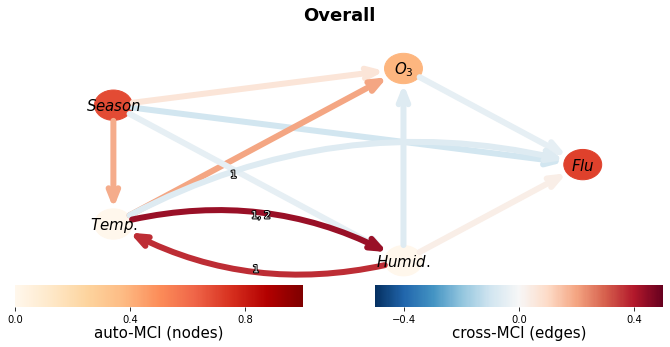

0.01


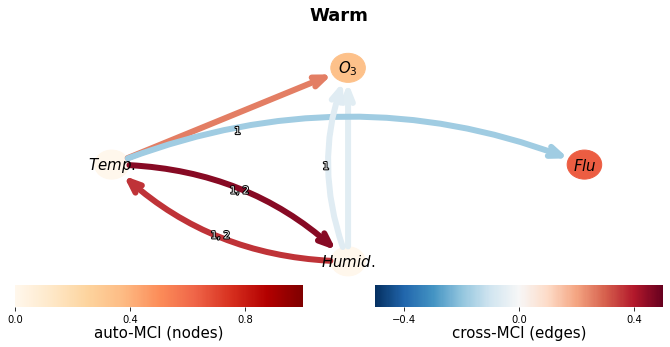

0.01


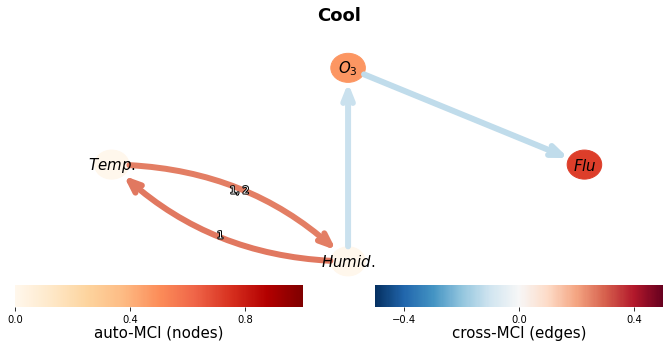

0.01


In [8]:
pc_alpha = 0.01

results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Season$', r'$Temp.$', r'$Humid.$'],
                      season="Year",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Overall"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Warm",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Warm"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Cool",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Cool"
                      )
print(pc_alpha)

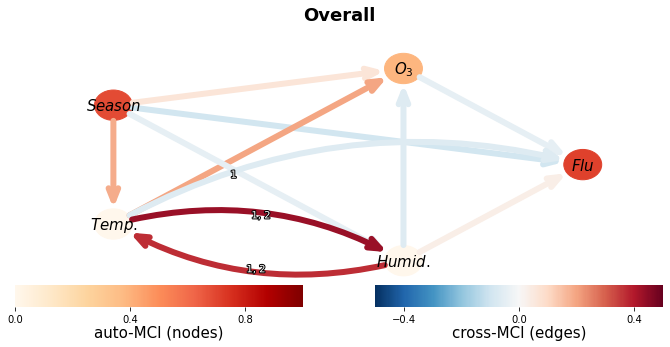

0.1


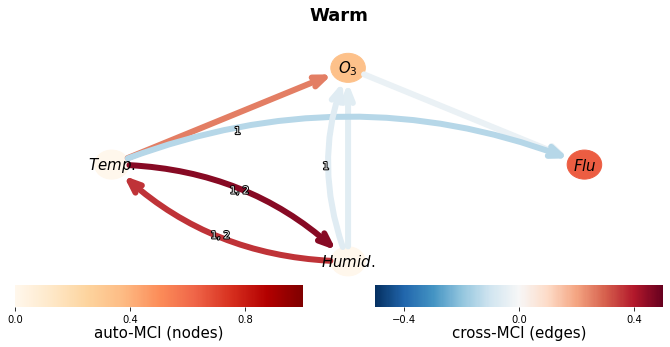

0.1


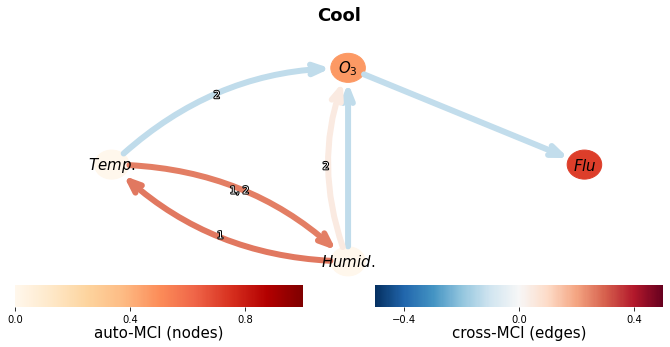

0.1


In [9]:
pc_alpha = 0.1

results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Season$', r'$Temp.$', r'$Humid.$'],
                      season="Year",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Overall"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Warm",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Warm"
                      )
print(pc_alpha)


results = apply_pcmci(data_all=data_all,
                      state="Overall",
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Cool",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0,
                      name="Cool"
                      )
print(pc_alpha)

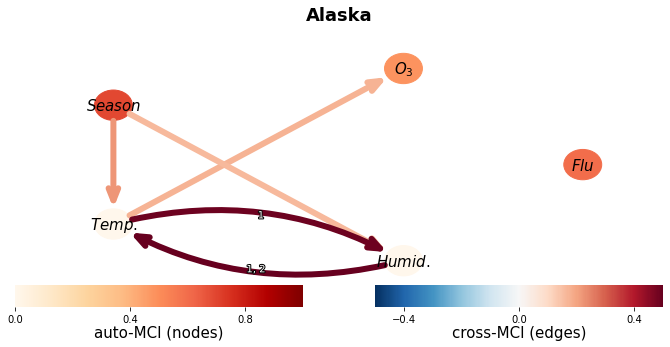

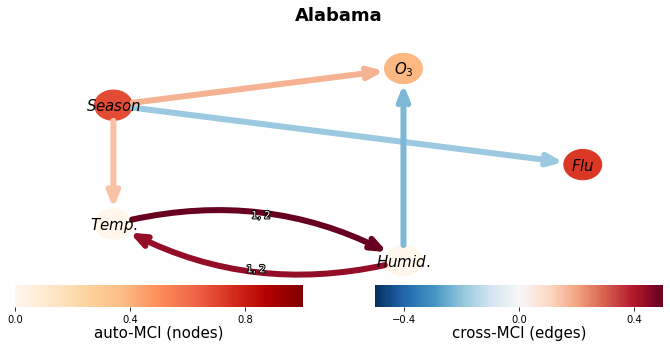

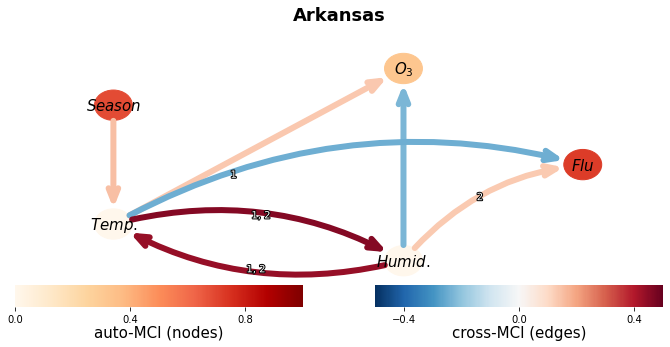

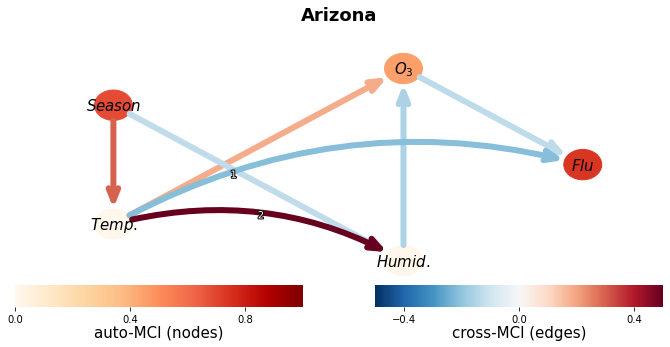

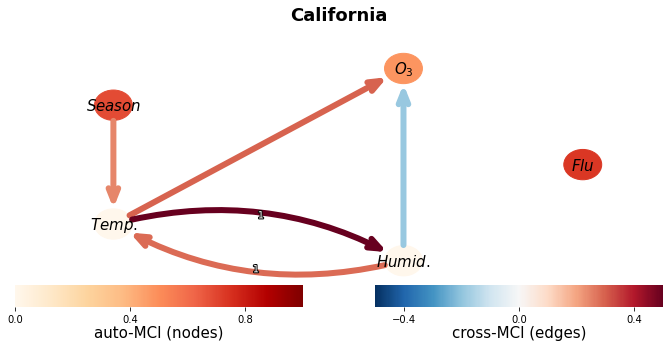

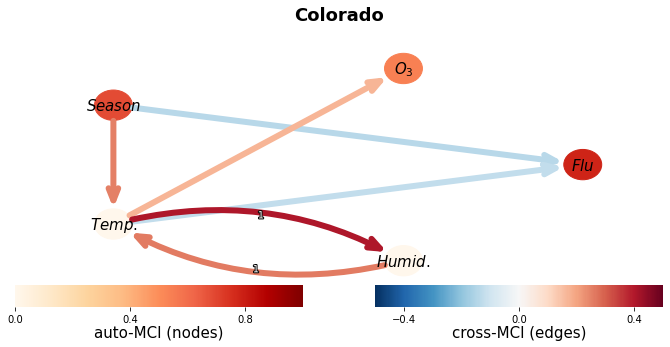

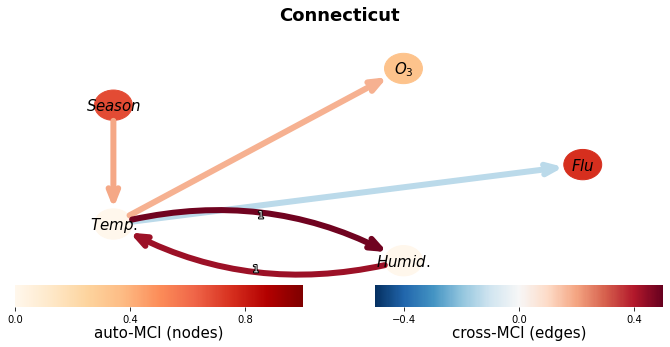

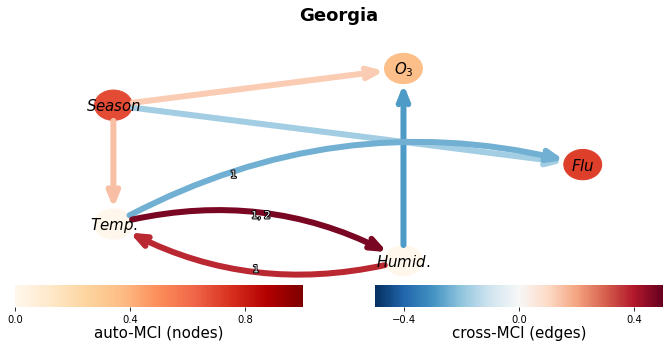

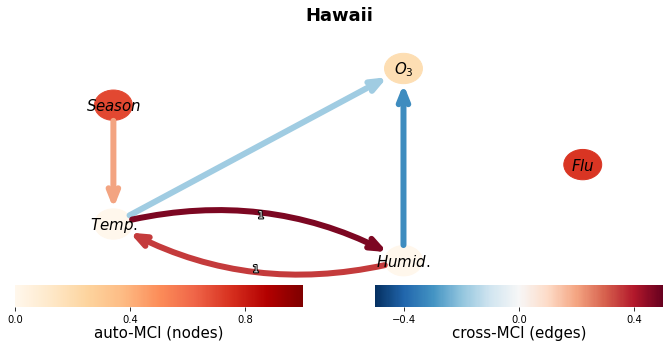

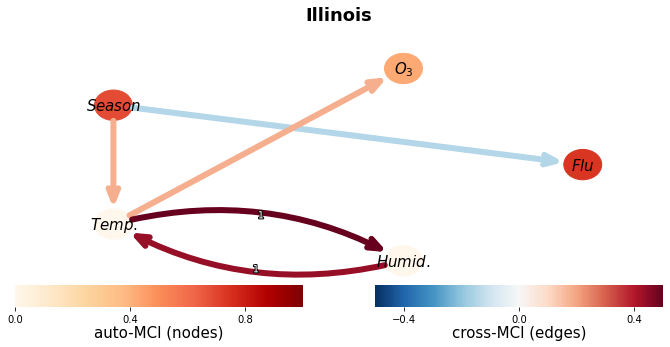

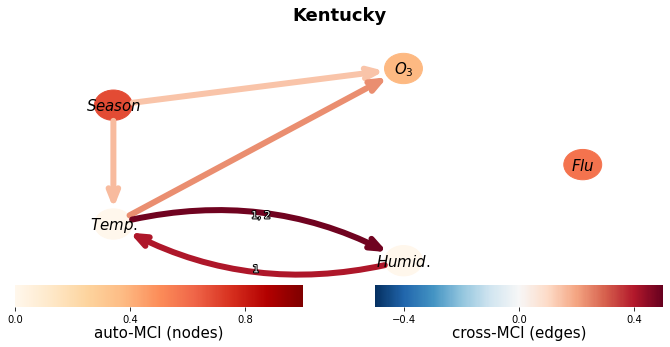

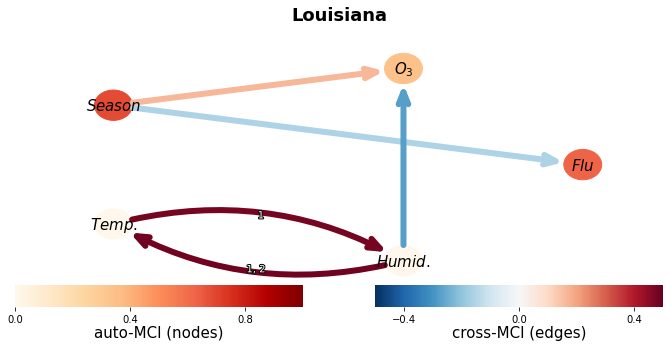

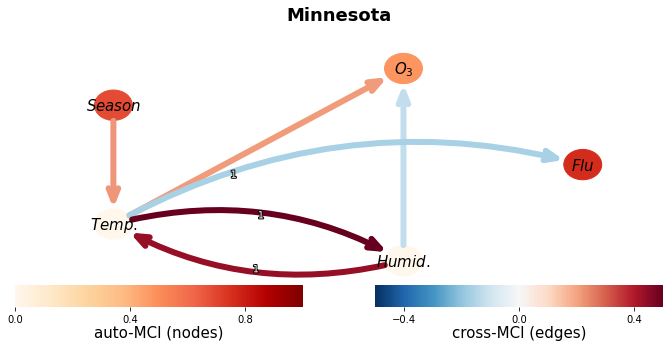

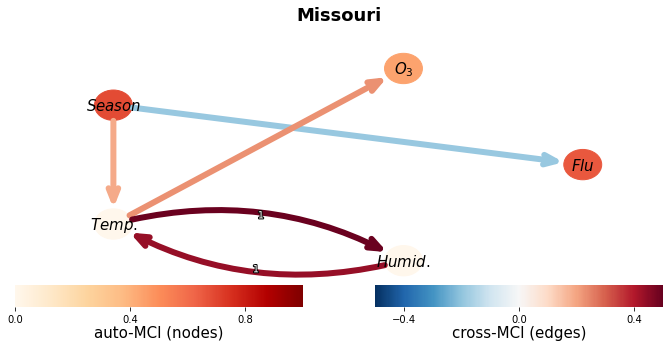

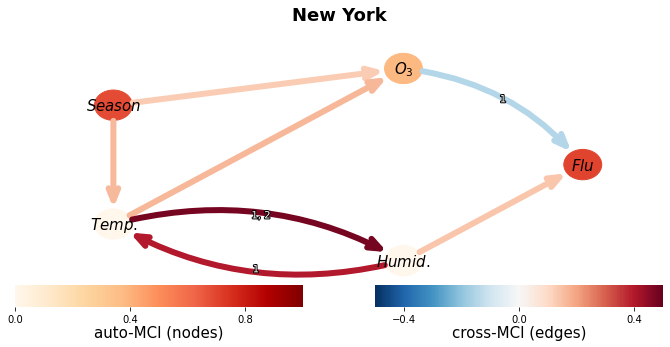

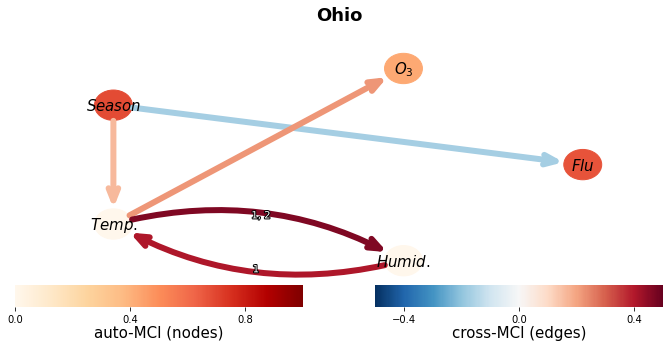

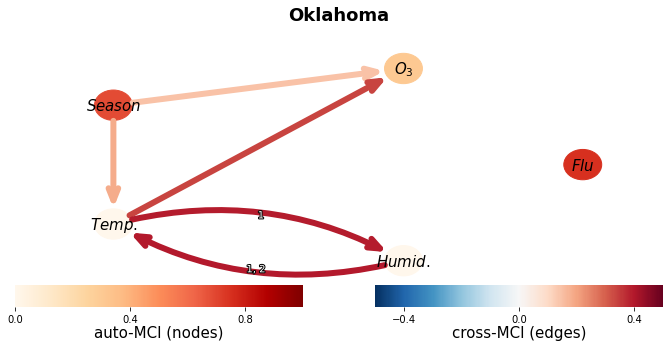

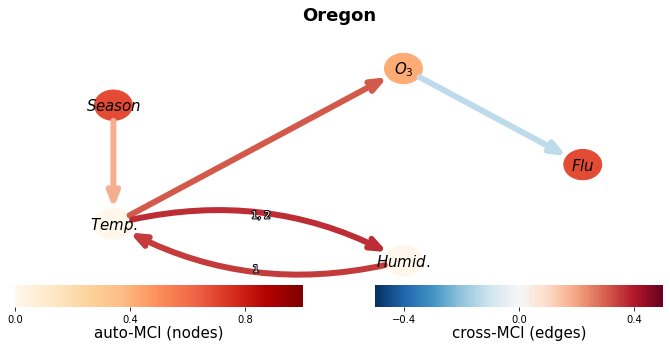

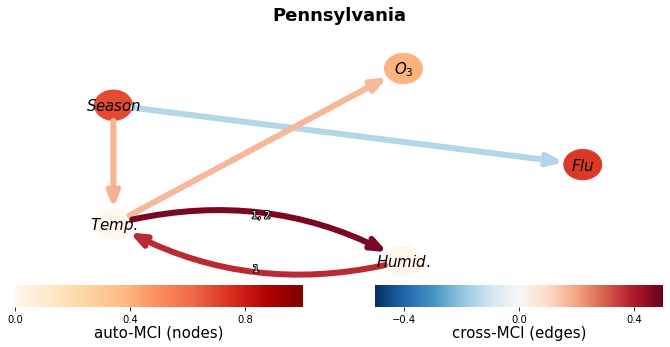

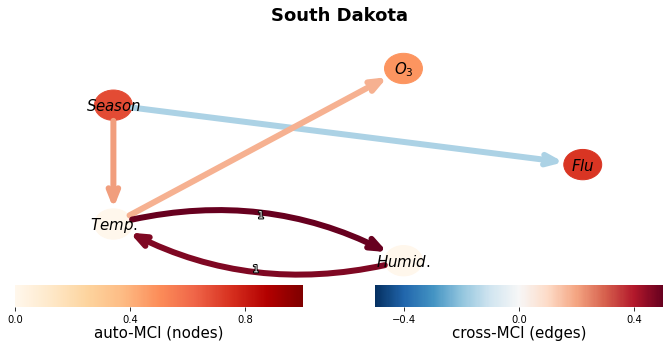

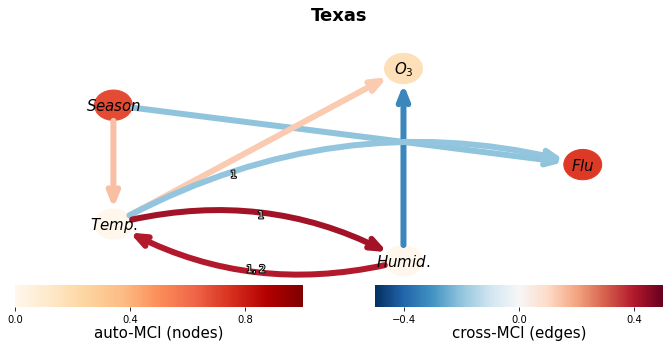

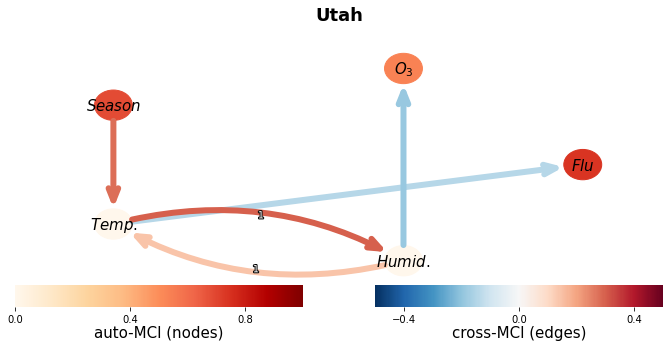

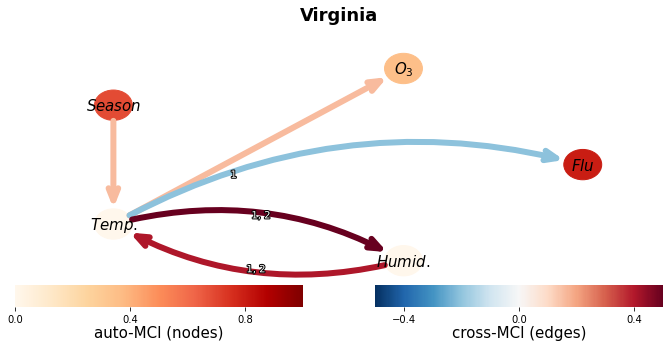

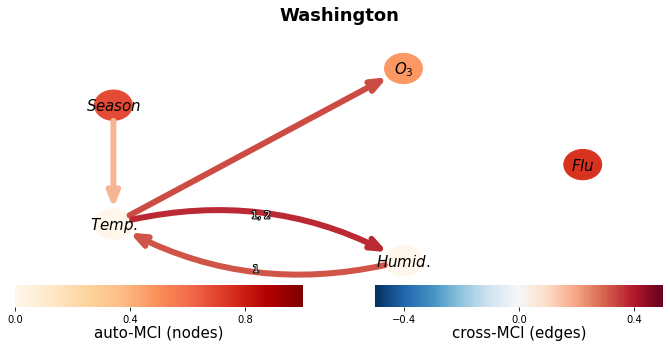

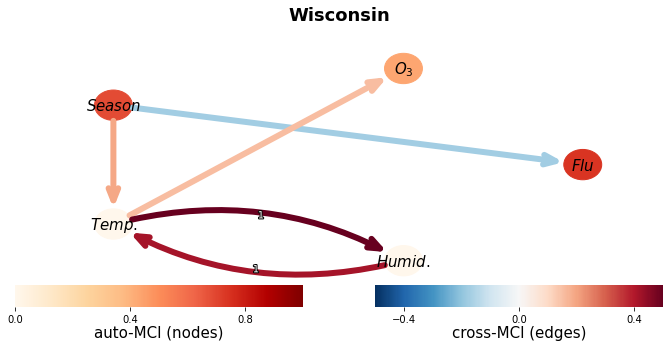

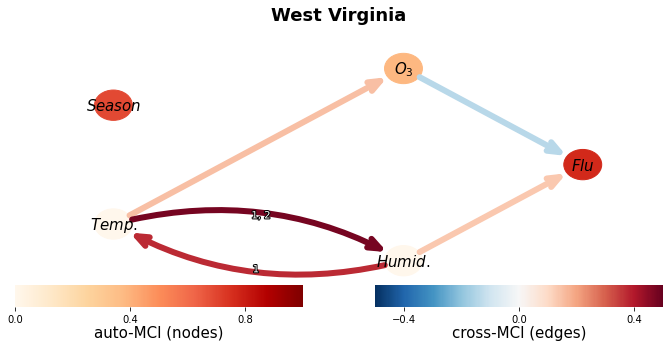

In [11]:
def apply_pcmci(data_all,
                state,
                var_names,
                season,
                tau_min,
                tau_max,
                pc_alpha,
                verbosity):
    # Get the data and mask
    data, mask = get_data_and_mask(data_all=data_all,
                                   state=state,
                                   season=season,
                                   var_names=var_names)

    # Prepare the DataFrame object
    dataframe = pp.DataFrame(data,
                             mask=mask,
                             var_names=var_names,
                             missing_flag=999.)

    # Prepare the independence test and PCMCI object
    if season == "Year":
#        gpdc = GPDC()
        parcorr = ParCorr()
    else:
#        gpdc = GPDC(mask_type='y')
        parcorr = ParCorr(mask_type='y')
    pcmci = PCMCI(dataframe=dataframe,
                  cond_ind_test=parcorr,
                  verbosity=verbosity)

    # Get the selected_links arguement
    selected_links = get_selected_links(var_names,
                                        tau_min,
                                        tau_max)

    # Run PCMCI^+ with these parameters
    results = pcmci.run_pcmciplus(tau_min=tau_min,
                                  tau_max=tau_max,
                                  pc_alpha=pc_alpha,
                                  selected_links=selected_links)
    
#     c3d = results['val_matrix']
#     c2d = c3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     c_df = pd.DataFrame(c2d)
#     c_df_t = c_df.transpose()
#     c_df_t["state"] = state
#     feather.write_feather(c_df_t, 'finalc_df%s_%s.feather' % (state,season))

#     p3d = results['p_matrix']
#     p2d = p3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     p_df = pd.DataFrame(p2d)
#     p_df_t = p_df.transpose()
#     p_df_t["state"] = state
#     feather.write_feather(p_df_t, 'finalp_df%s_%s.feather' % (state,season))

#     l3d = results['graph']
#     l2d = l3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     l_df = pd.DataFrame(l2d)
#     l_df_t = l_df.transpose()
#     l_df_t["state"] = state
#     feather.write_feather(l_df_t, 'finall_df%s_%s.feather' % (state,season))
    
    tp.plot_graph(
        arrow_linewidth=12.0,
        figsize=(10, 5),
        vmin_edges=-0.5,
        vmax_edges=0.5,
        node_label_size=15,
        link_label_fontsize=10,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        label_fontsize=15,
        network_lower_bound=0.2,
        show_colorbar=1
    );

    plt.suptitle(state,
                 size=18,
                 weight="semibold",
                 verticalalignment="top",
                 horizontalalignment="center")
    plt.savefig('final_%s_%s_%s.png' % (state, season, pc_alpha), dpi=500)
    plt.show()

    return results

data_all = pd.read_csv("usaflu_raw_M.csv")
data_all.rename(columns={'fluP': r'$Flu$',
                         'o3': r'$O_{3}$',
                         'season': r'$Season$',
                         'temp': r'$Temp.$',
                         'ah': r'$Humid.$'}, inplace=True)

    
states = [ "Alaska","Alabama","Arkansas","Arizona","California","Colorado","Connecticut","Georgia","Hawaii","Illinois",
"Kentucky","Louisiana","Minnesota","Missouri","New York","Ohio","Oklahoma","Oregon","Pennsylvania",
"South Dakota","Texas","Utah","Virginia","Washington","Wisconsin","West Virginia"]
# pc_alpha = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75,
#            0.8, 0.85, 0.9, 0.95]
pc_alpha = 0.05
for state in states:
    results = apply_pcmci(data_all=data_all,
                      state=state,
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Season$', r'$Temp.$', r'$Humid.$'],
                      season="Year",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0
                      )

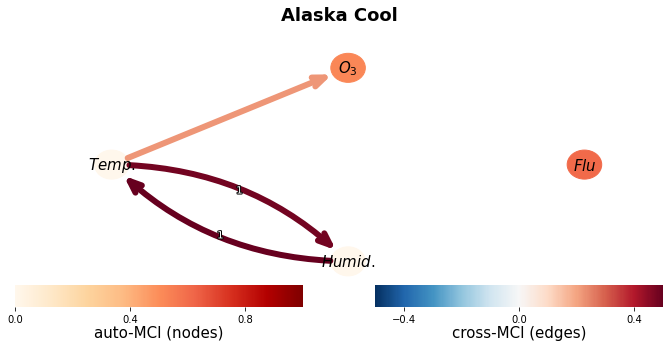

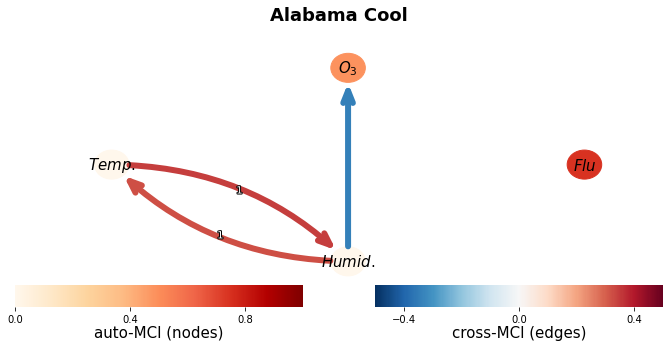

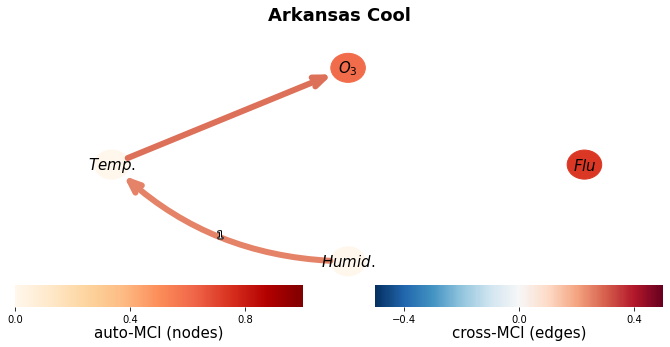

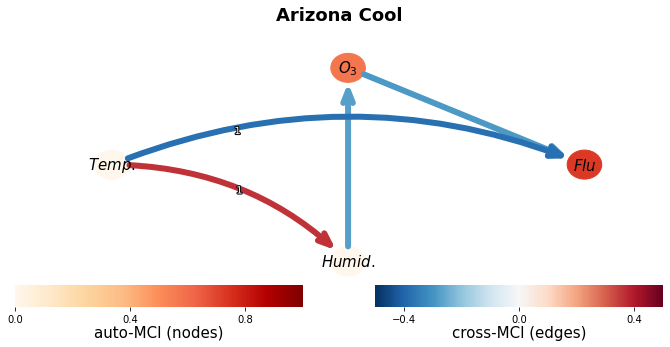

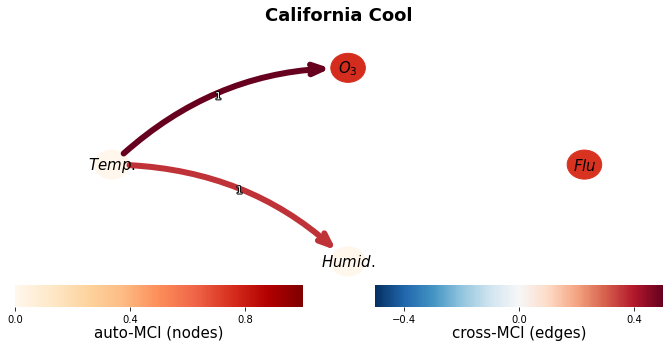

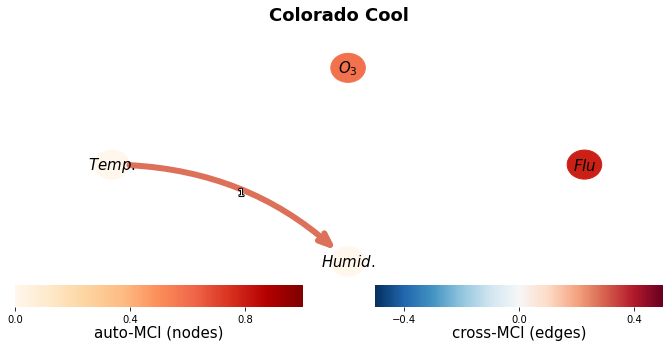

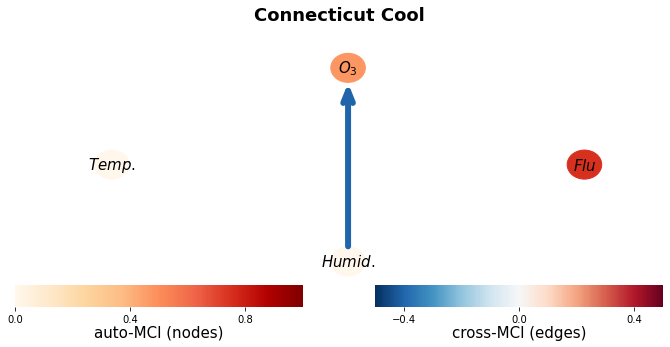

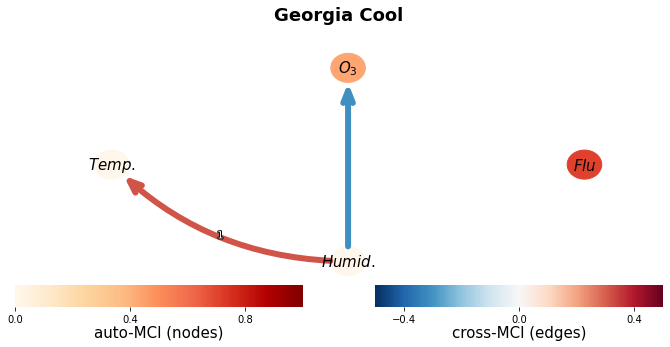

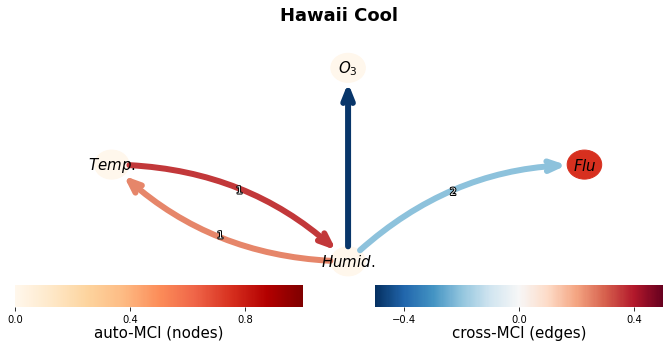

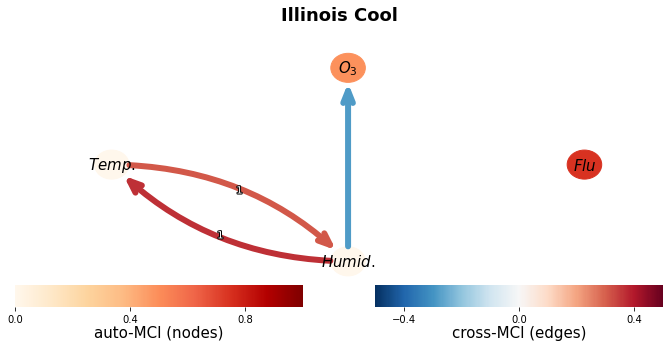

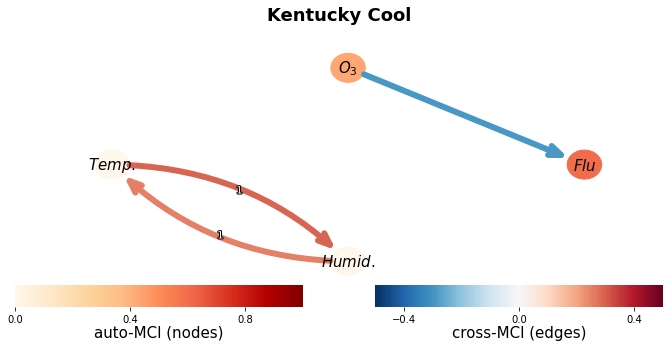

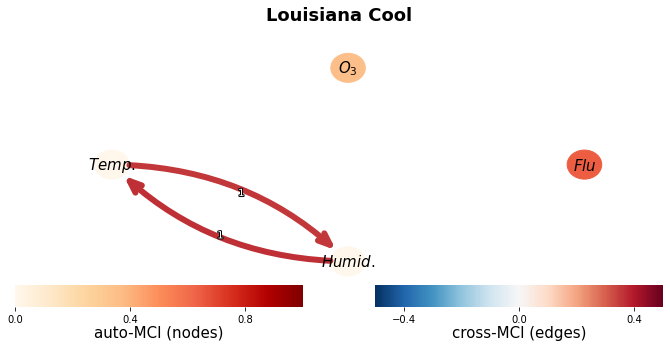

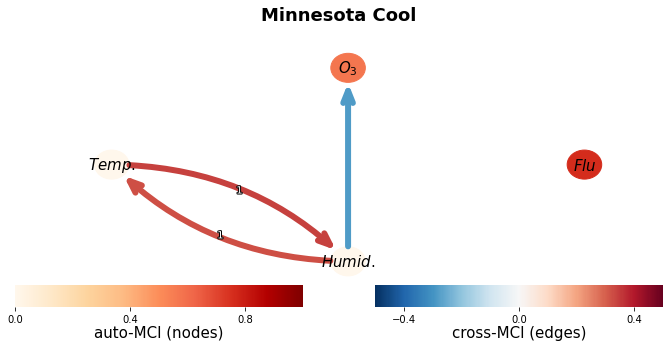

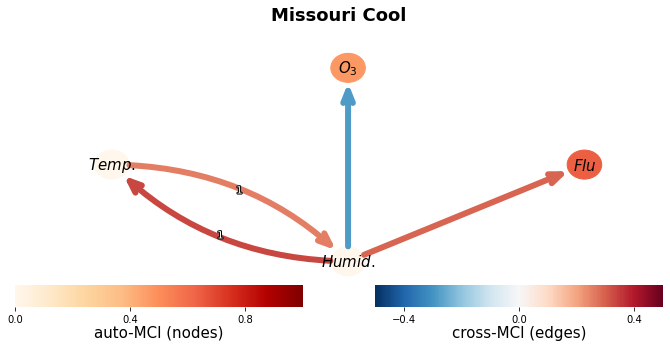

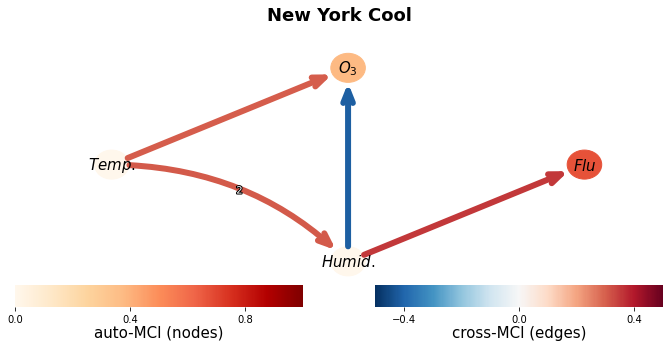

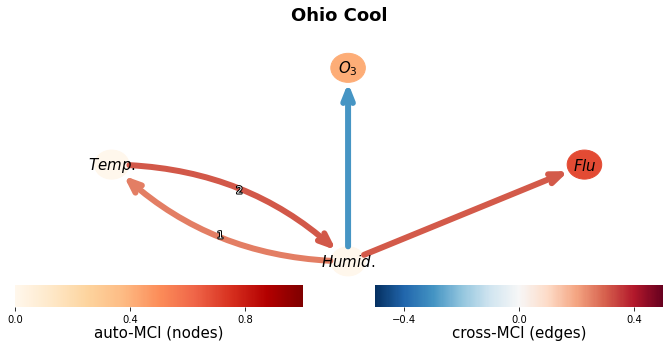

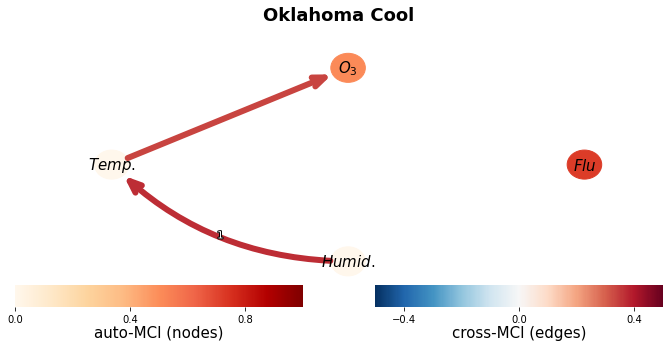

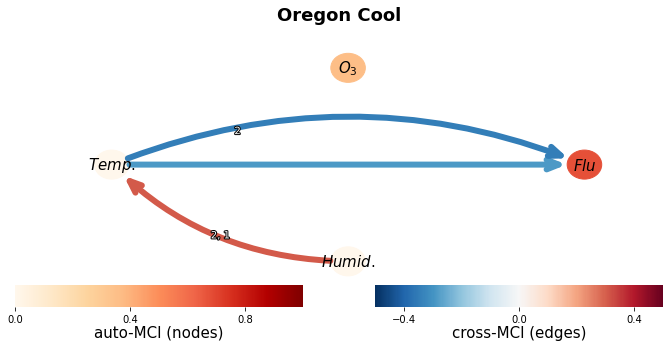

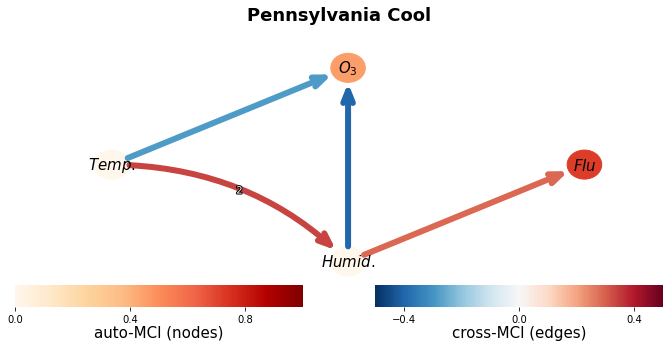

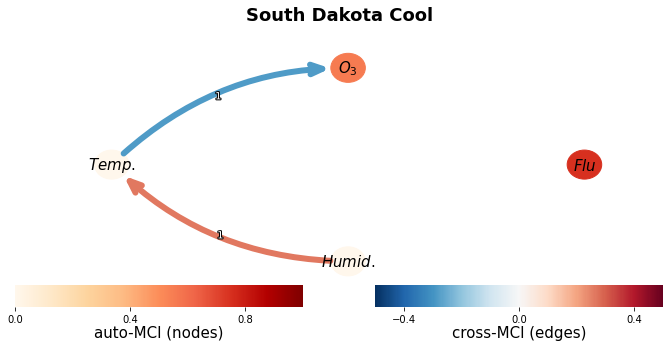

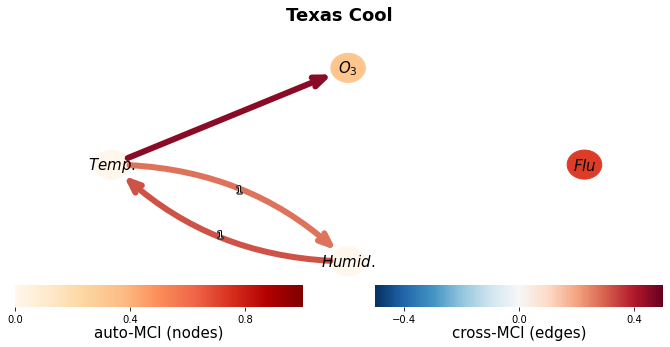

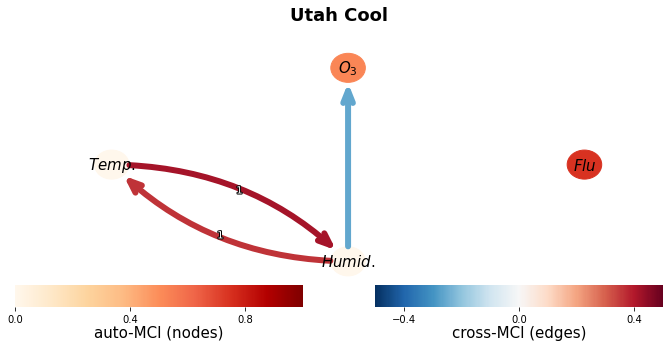

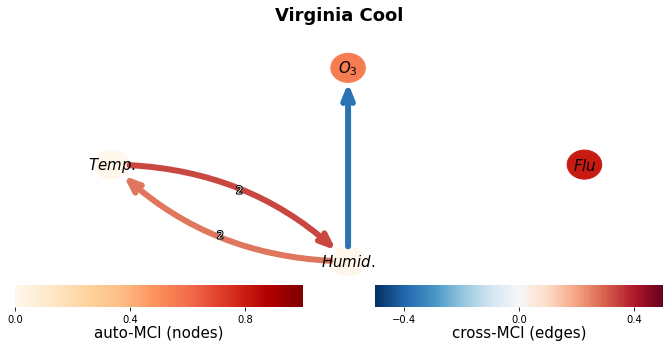

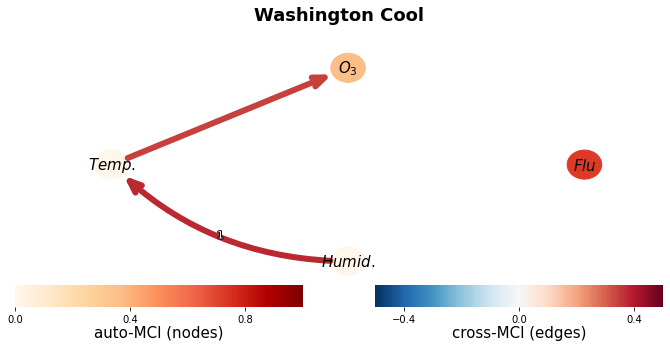

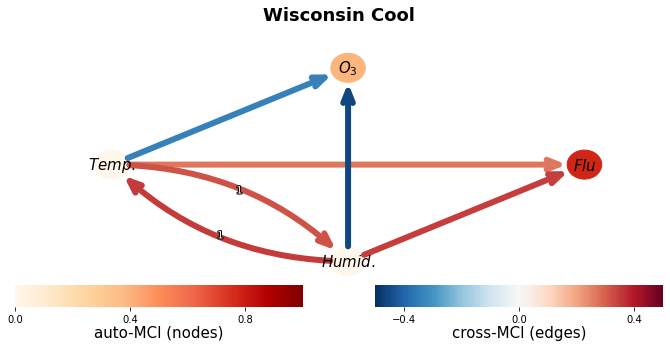

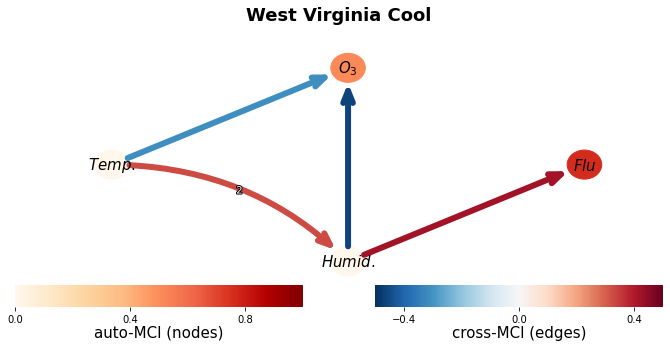

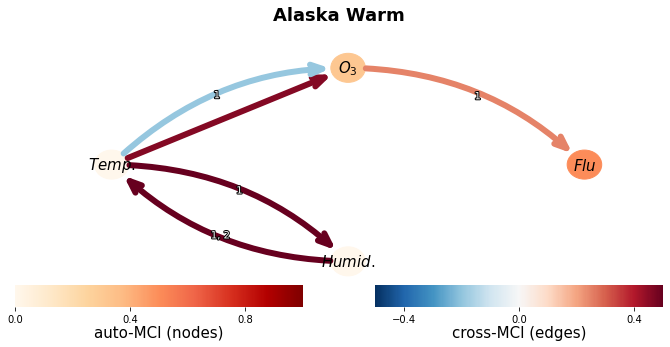

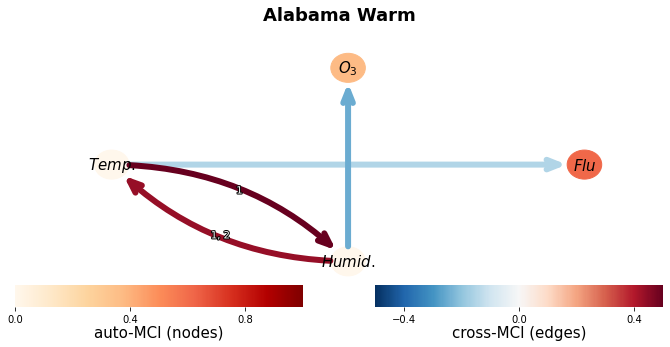

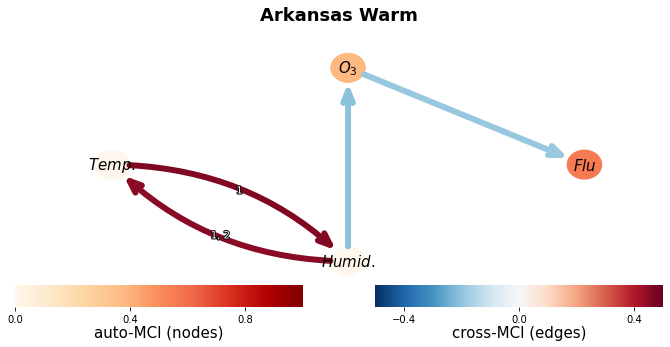

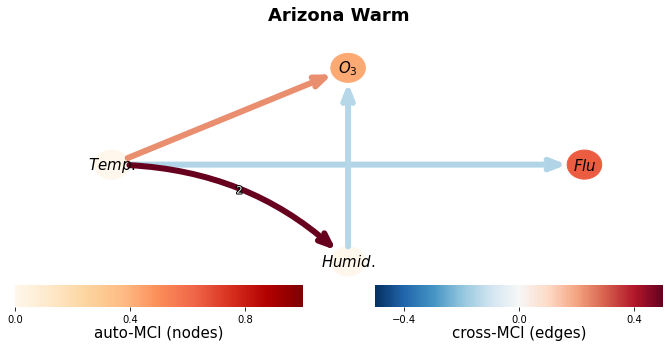

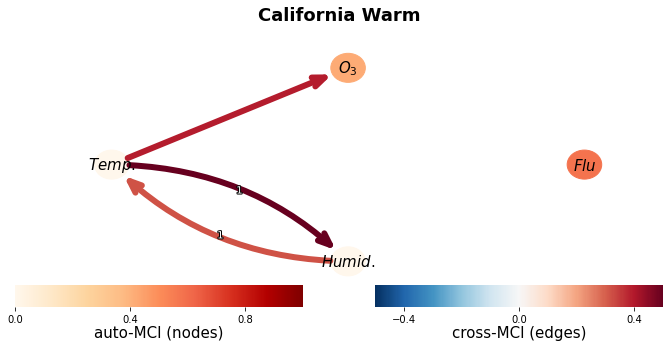

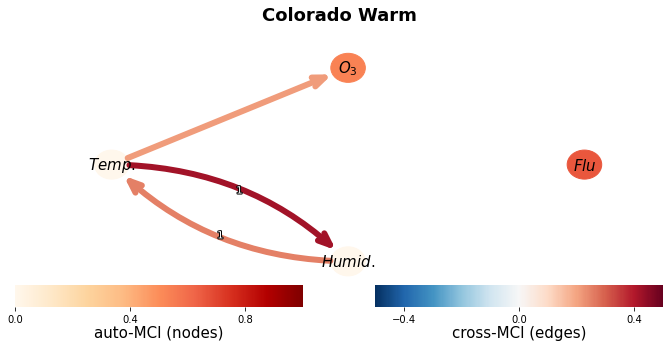

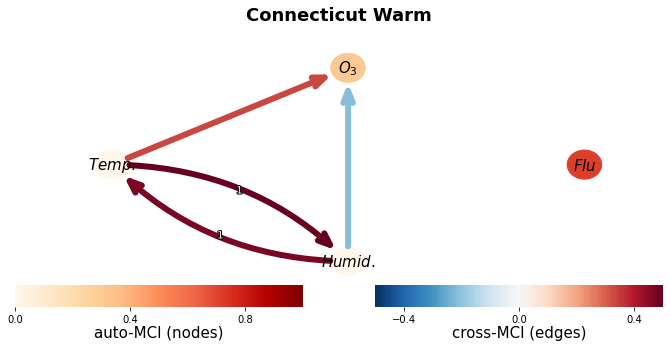

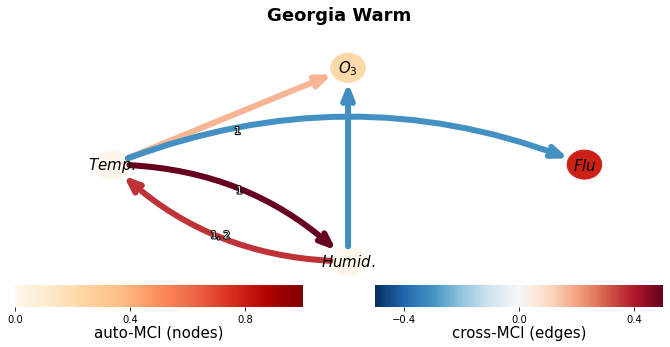

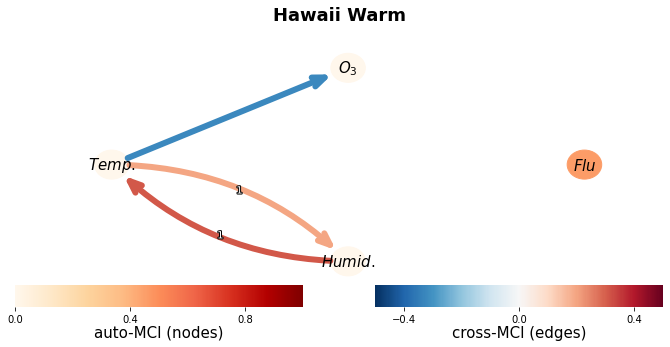

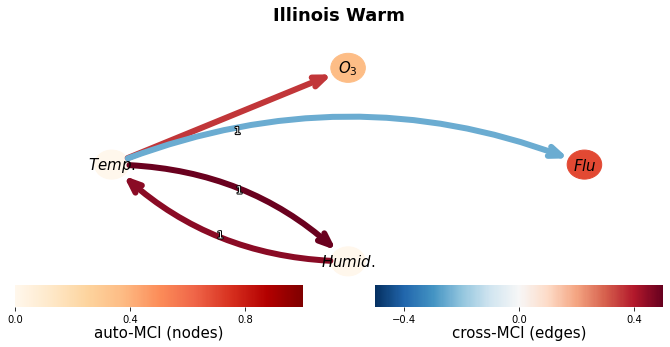

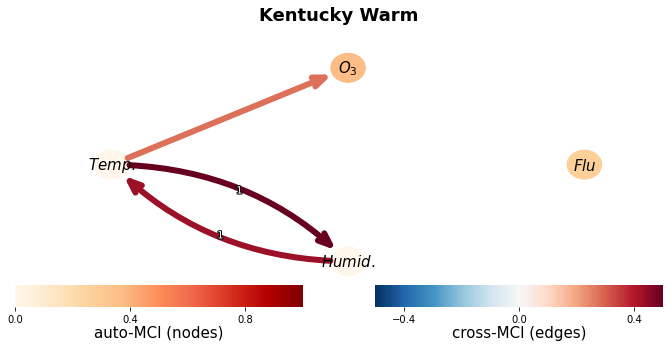

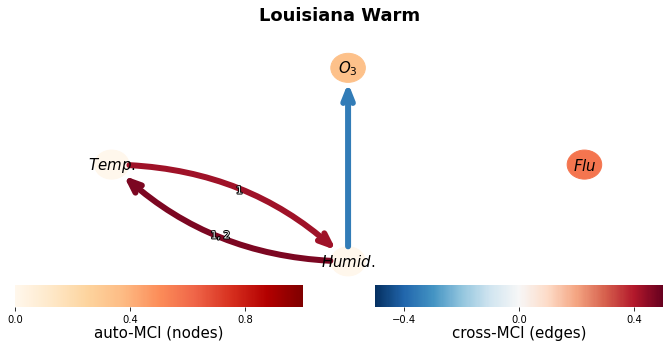

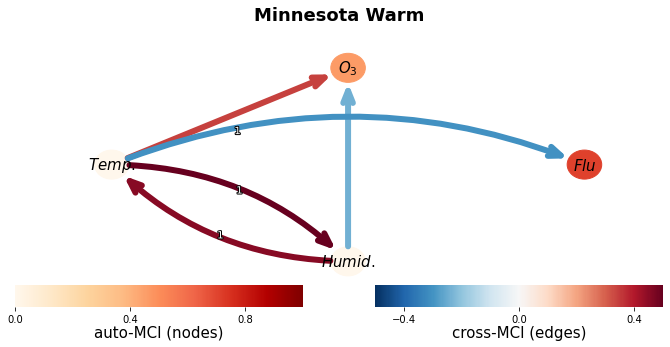

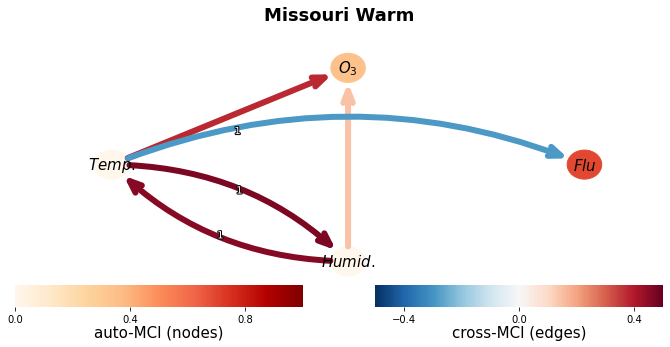

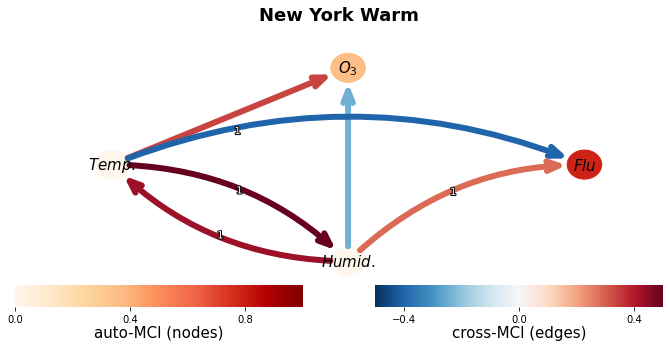

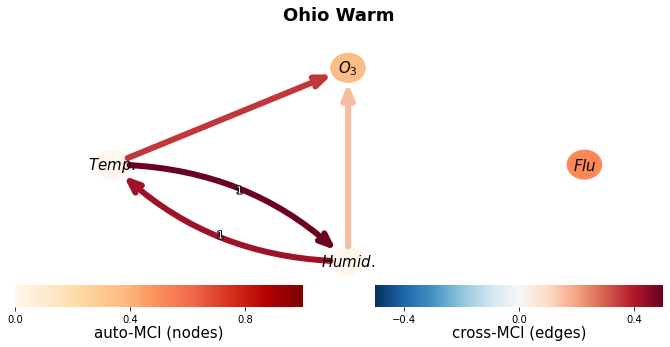

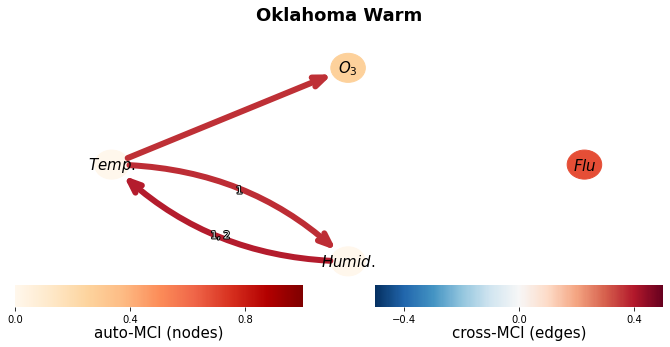

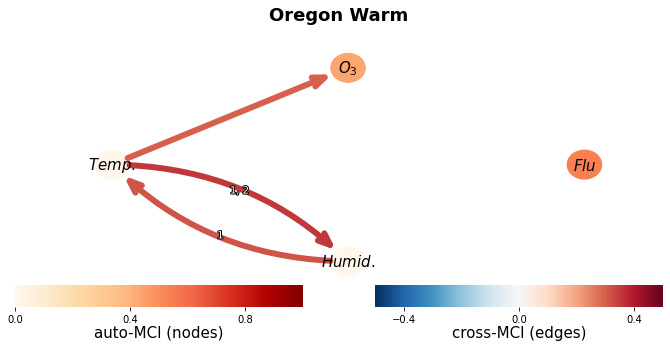

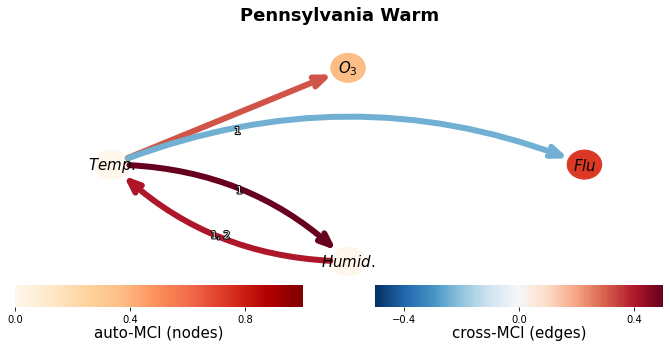

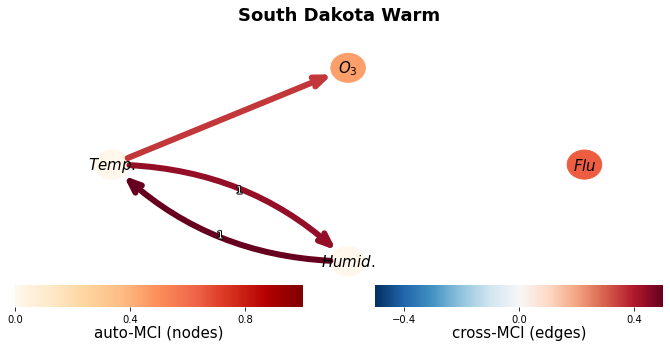

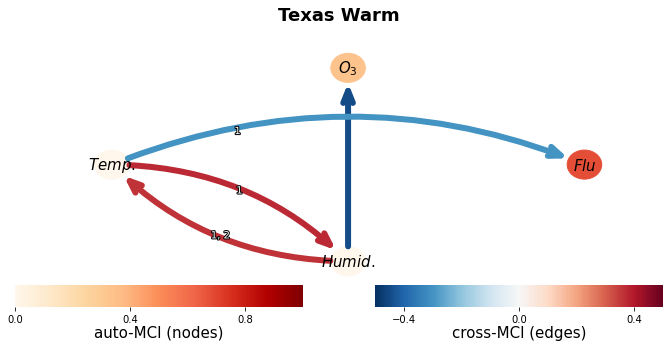

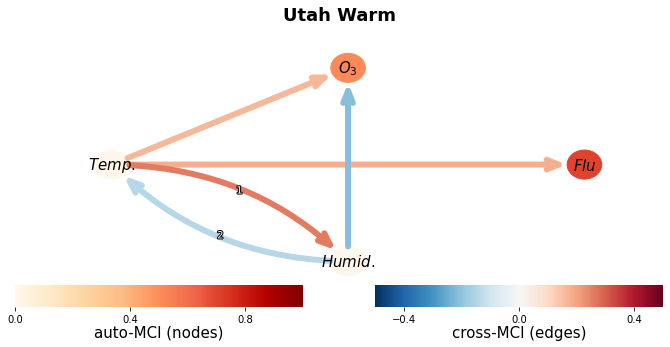

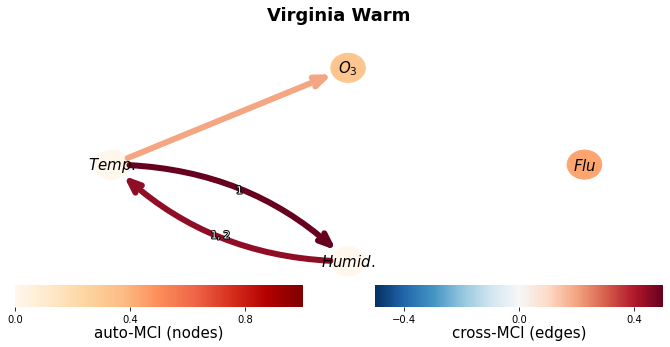

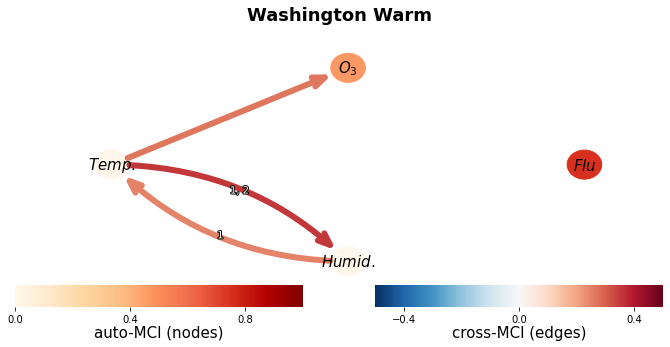

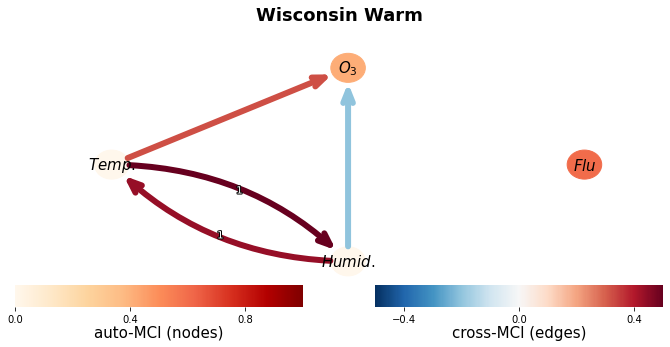

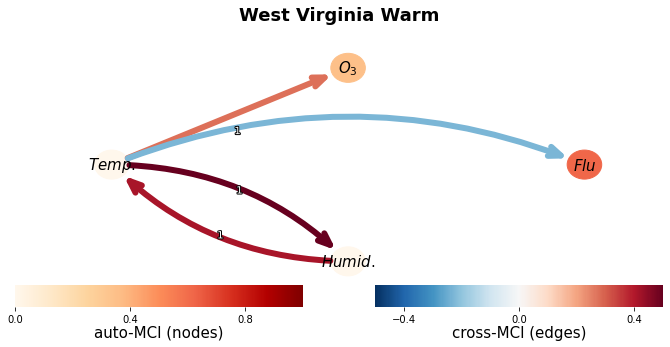

In [12]:
def apply_pcmci(data_all,
                state,
                var_names,
                season,
                tau_min,
                tau_max,
                pc_alpha,
                verbosity):
    # Get the data and mask
    data, mask = get_data_and_mask(data_all=data_all,
                                   state=state,
                                   season=season,
                                   var_names=var_names)

    # Prepare the DataFrame object
    dataframe = pp.DataFrame(data,
                             mask=mask,
                             var_names=var_names,
                             missing_flag=999.)

    # Prepare the independence test and PCMCI object
    if season == "Year":
#        gpdc = GPDC()
        parcorr = ParCorr()
    else:
#        gpdc = GPDC(mask_type='y')
        parcorr = ParCorr(mask_type='y')
    pcmci = PCMCI(dataframe=dataframe,
                  cond_ind_test=parcorr,
                  verbosity=verbosity)

    # Get the selected_links arguement
    selected_links = get_selected_links(var_names,
                                        tau_min,
                                        tau_max)

    # Run PCMCI^+ with these parameters
    results = pcmci.run_pcmciplus(tau_min=tau_min,
                                  tau_max=tau_max,
                                  pc_alpha=pc_alpha,
                                  selected_links=selected_links)
    
#     c3d = results['val_matrix']
#     c2d = c3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     c_df = pd.DataFrame(c2d)
#     c_df_t = c_df.transpose()
#     c_df_t["state"] = state
#     feather.write_feather(c_df_t, 'finalc_df%s_%s.feather' % (state,season))

#     p3d = results['p_matrix']
#     p2d = p3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     p_df = pd.DataFrame(p2d)
#     p_df_t = p_df.transpose()
#     p_df_t["state"] = state
#     feather.write_feather(p_df_t, 'finalp_df%s_%s.feather' % (state,season))

#     l3d = results['graph']
#     l2d = l3d.transpose(2, 0, 1).reshape(tau_max + 1, -1)
#     l_df = pd.DataFrame(l2d)
#     l_df_t = l_df.transpose()
#     l_df_t["state"] = state
#     feather.write_feather(l_df_t, 'finall_df%s_%s.feather' % (state,season))
    
    tp.plot_graph(
        arrow_linewidth=12.0,
        figsize=(10, 5),
        vmin_edges=-0.5,
        vmax_edges=0.5,
        node_label_size=15,
        link_label_fontsize=10,
        val_matrix=results['val_matrix'],
        graph=results['graph'],
        var_names=var_names,
        link_colorbar_label='cross-MCI (edges)',
        node_colorbar_label='auto-MCI (nodes)',
        label_fontsize=15,
        network_lower_bound=0.2,
        show_colorbar=1
    );

    plt.suptitle(state+" "+season,
                 size=18,
                 weight="semibold",
                 verticalalignment="top",
                 horizontalalignment="center")
    plt.savefig('final_%s_%s_%s.png' % (state, season, pc_alpha), dpi=500)
    plt.show()

    return results

for state in states:
    results = apply_pcmci(data_all=data_all,
                      state=state,
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Cool",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0
                      )
    #print(results["optimal_alpha"])

# pc_alpha = [0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75,
#            0.8, 0.85, 0.9, 0.95]
pc_alpha = 0.05
for state in states:
    results = apply_pcmci(data_all=data_all,
                      state=state,
                      var_names=[r'$Flu$', r'$O_{3}$', r'$Temp.$', r'$Humid.$'],
                      season="Warm",
                      tau_min=0,
                      tau_max=2,
                      pc_alpha=pc_alpha,
                      verbosity=0
                      )
    #print(results["optimal_alpha"])